In [9]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.arima.model import ARIMA

# Load dataset (using your Windows file path)
df = pd.read_csv(r"C:\Users\prana\Downloads\ProductPriceIndex.csv")

# Clean numeric columns with coercion
price_cols = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for col in price_cols:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
df['averagespread'] = pd.to_numeric(df['averagespread'].str.rstrip('%'), errors='coerce') / 100

# Drop rows with any missing numeric
df = df.dropna(subset=price_cols + ['averagespread'])

# Parse date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Assign seasons
def assign_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(assign_season)

# Prepare transactions: high-spread items per season-year
df['high_spread'] = df.groupby(['year', 'season'])['averagespread'] \
                      .transform(lambda x: x >= x.quantile(0.75))
trans = df[df['high_spread']].groupby(['year', 'season'])['productname'].apply(list)
transactions = list(trans)
n_trans = len(transactions)

# Manual Apriori-like analysis
min_support = 0.3
# Single supports
item_counts = {}
for trx in transactions:
    for item in set(trx):
        item_counts[item] = item_counts.get(item, 0) + 1

freq_items = {item for item, count in item_counts.items() if count/n_trans >= min_support}

# Pair counts
pair_counts = {}
for trx in transactions:
    items = [i for i in set(trx) if i in freq_items]
    for i, j in combinations(sorted(items), 2):
        pair_counts[(i, j)] = pair_counts.get((i, j), 0) + 1

# Build rules
rules_list = []
for (i, j), count in pair_counts.items():
    support = count / n_trans
    conf_i_j = count / item_counts[i]
    lift_i_j = conf_i_j / (item_counts[j] / n_trans)
    if support >= min_support and lift_i_j >= 1.2:
        rules_list.append([i, j, support, conf_i_j, lift_i_j])

rules_df = pd.DataFrame(rules_list, columns=['antecedent', 'consequent', 'support', 'confidence', 'lift']) \
              .sort_values('lift', ascending=False).head(5)

# ARIMA forecasting for 'Potatoes'
series = df[df['productname']=='Potatoes'].set_index('date')['farmprice'] \
            .resample('W').mean().interpolate()
model = ARIMA(series, order=(1,1,1)).fit()
forecast = model.get_forecast(steps=12)
fc_df = forecast.summary_frame()

# Display results
print("Top 5 Association Rules (Apriori-like):")
print(rules_df)
print("\nARIMA Forecast for Potatoes (next 12 weeks):")
print(fc_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])


Top 5 Association Rules (Apriori-like):
         antecedent       consequent  support  confidence      lift
0  Broccoli Bunches  Broccoli Crowns    0.525    0.857143  1.318681
1        Cantaloupe           Celery    0.450    0.947368  1.263158

ARIMA Forecast for Potatoes (next 12 weeks):
farmprice       mean  mean_ci_lower  mean_ci_upper
2019-05-26  1.488694       1.038967       1.938420
2019-06-02  1.478789       0.877874       2.079704
2019-06-09  1.470113       0.772817       2.167409
2019-06-16  1.462513       0.697591       2.227435
2019-06-23  1.455855       0.641275       2.270435
2019-06-30  1.450023       0.597964       2.302082
2019-07-07  1.444914       0.564022       2.325807
2019-07-14  1.440439       0.537036       2.343842
2019-07-21  1.436519       0.515328       2.357710
2019-07-28  1.433085       0.497686       2.368483
2019-08-04  1.430076       0.483218       2.376935
2019-08-11  1.427441       0.471252       2.383630


<Figure size 640x480 with 0 Axes>

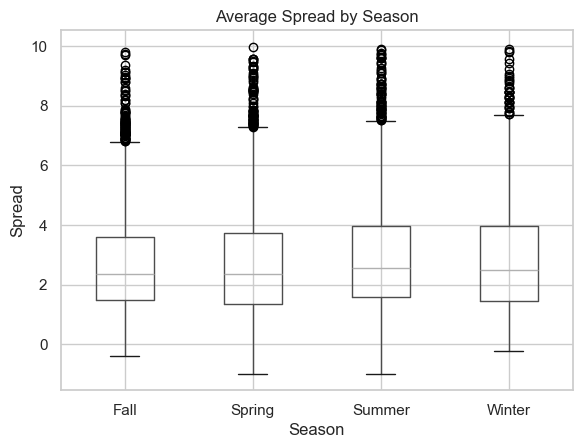

<Figure size 640x480 with 0 Axes>

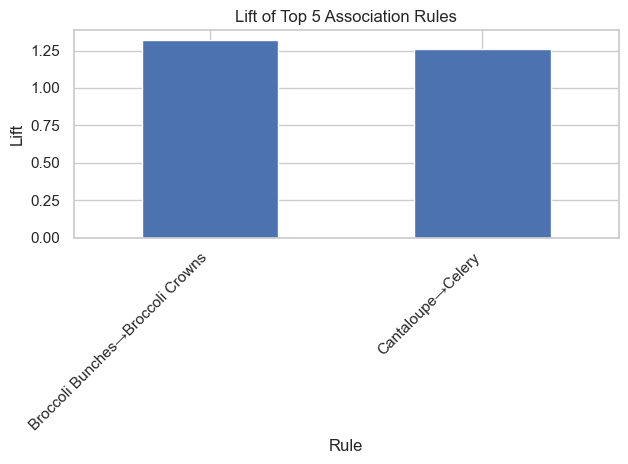

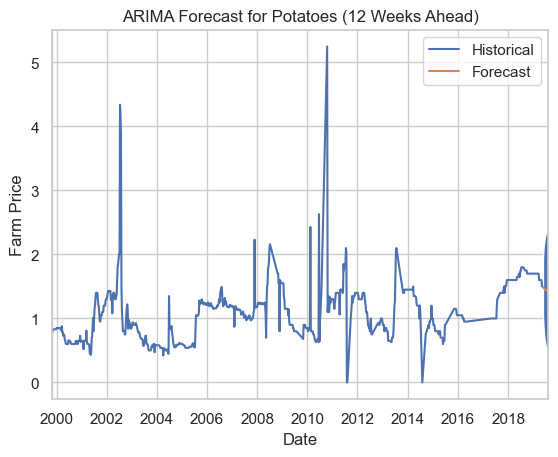

In [10]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load dataset (try Windows path, fallback to sandbox path)
try:
    df = pd.read_csv(r"C:\Users\prana\Downloads\ProductPriceIndex.csv")
except FileNotFoundError:
    df = pd.read_csv('/mnt/data/ProductPriceIndex.csv')

# Clean numeric columns
price_cols = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for col in price_cols:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
df['averagespread'] = pd.to_numeric(df['averagespread'].str.rstrip('%'), errors='coerce') / 100
df = df.dropna(subset=price_cols + ['averagespread', 'date'])

# Parse dates and assign seasons
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
def assign_season(m):
    if m in [12,1,2]: return 'Winter'
    if m in [3,4,5]: return 'Spring'
    if m in [6,7,8]: return 'Summer'
    return 'Fall'
df['season'] = df['month'].apply(assign_season)

# Prepare transactions for Apriori-like
df['high_spread'] = df.groupby(['year','season'])['averagespread'] \
                      .transform(lambda x: x >= x.quantile(0.75))
trans = df[df['high_spread']].groupby(['year','season'])['productname'].apply(list)
transactions = list(trans)
n_trans = len(transactions)

# Compute supports and rules
min_support = 0.3
item_counts = {}
for trx in transactions:
    for item in set(trx):
        item_counts[item] = item_counts.get(item,0)+1
freq_items = {item for item,c in item_counts.items() if c/n_trans >= min_support}

pair_counts = {}
for trx in transactions:
    items = [i for i in set(trx) if i in freq_items]
    for i,j in combinations(sorted(items),2):
        pair_counts[(i,j)] = pair_counts.get((i,j),0)+1

rules = []
for (i,j),count in pair_counts.items():
    support = count/n_trans
    conf = count/item_counts[i]
    lift = conf / (item_counts[j]/n_trans)
    if support>=min_support and lift>=1.2:
        rules.append((f"{i}→{j}", support, conf, lift))
rules_df = pd.DataFrame(rules, columns=['rule','support','confidence','lift']) \
                   .sort_values('lift', ascending=False).head(5)

# Time series and forecast for 'Potatoes'
series = df[df['productname']=='Potatoes'].set_index('date')['farmprice'] \
            .resample('W').mean().interpolate()
model = ARIMA(series, order=(1,1,1)).fit()
fc = model.get_forecast(steps=12)
fc_df = fc.summary_frame()

# Convert CI arrays to float numpy arrays
lower = np.array(fc_df['mean_ci_lower'].astype(float))
upper = np.array(fc_df['mean_ci_upper'].astype(float))

# Visualization 1: Seasonal spread distribution
plt.figure()
df.boxplot(column='averagespread', by='season')
plt.title('Average Spread by Season')
plt.suptitle('')
plt.xlabel('Season')
plt.ylabel('Spread')
plt.show()

# Visualization 2: Top 5 rule lifts
plt.figure()
rules_df.plot.bar(x='rule', y='lift', legend=False)
plt.title('Lift of Top 5 Association Rules')
plt.xlabel('Rule')
plt.ylabel('Lift')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 3: Historical & forecasted farm price for Potatoes
plt.figure()
series.plot(label='Historical')
fc_df['mean'].plot(label='Forecast')
plt.fill_between(fc_df.index, lower, upper)
plt.title('ARIMA Forecast for Potatoes (12 Weeks Ahead)')
plt.xlabel('Date')
plt.ylabel('Farm Price')
plt.legend()
plt.show()


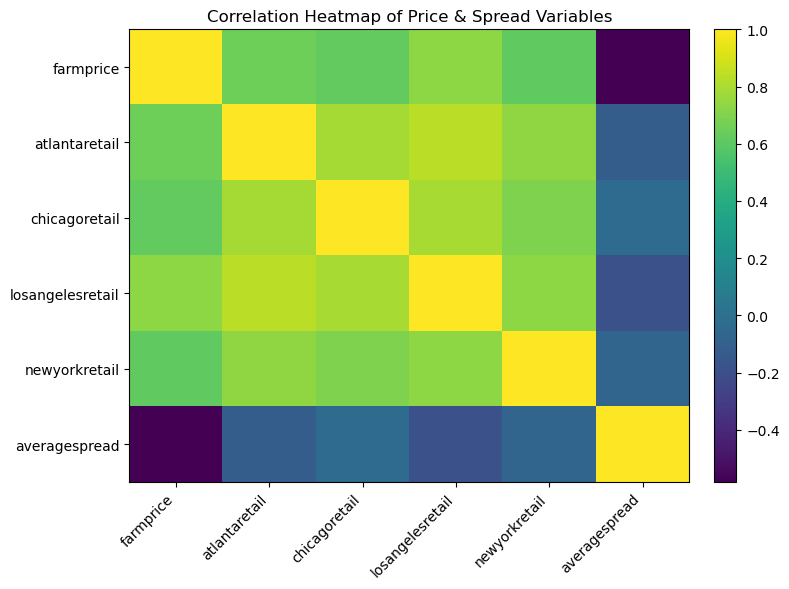

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (adjust path if needed)
try:
    df = pd.read_csv(r"C:\Users\prana\Downloads\ProductPriceIndex.csv")
except FileNotFoundError:
    df = pd.read_csv('/mnt/data/ProductPriceIndex.csv')

# Clean numeric columns
price_cols = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for col in price_cols:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
df['averagespread'] = pd.to_numeric(df['averagespread'].str.rstrip('%'), errors='coerce') / 100
df = df.dropna(subset=price_cols + ['averagespread'])

# Compute correlation matrix
corr = df[price_cols + ['averagespread']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Heatmap of Price & Spread Variables')
plt.tight_layout()
plt.show()


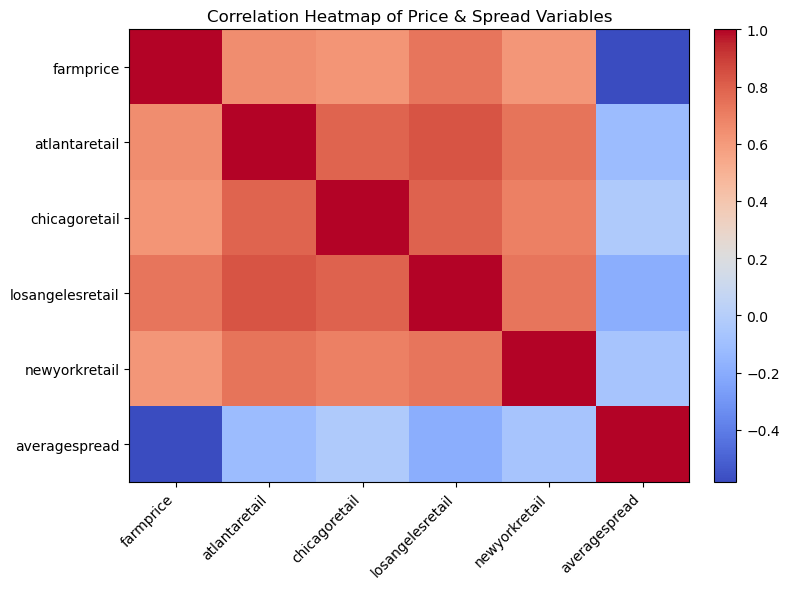

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (adjust path if needed)
try:
    df = pd.read_csv(r"C:\Users\prana\Downloads\ProductPriceIndex.csv")
except FileNotFoundError:
    df = pd.read_csv('/mnt/data/ProductPriceIndex.csv')

# Clean numeric columns
price_cols = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for col in price_cols:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
df['averagespread'] = pd.to_numeric(df['averagespread'].str.rstrip('%'), errors='coerce') / 100
df = df.dropna(subset=price_cols + ['averagespread'])

# Compute correlation matrix
corr = df[price_cols + ['averagespread']].corr()

# Plot heatmap with a more pleasant colormap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, interpolation='nearest', aspect='auto', cmap='coolwarm')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Heatmap of Price & Spread Variables')
plt.tight_layout()
plt.show()


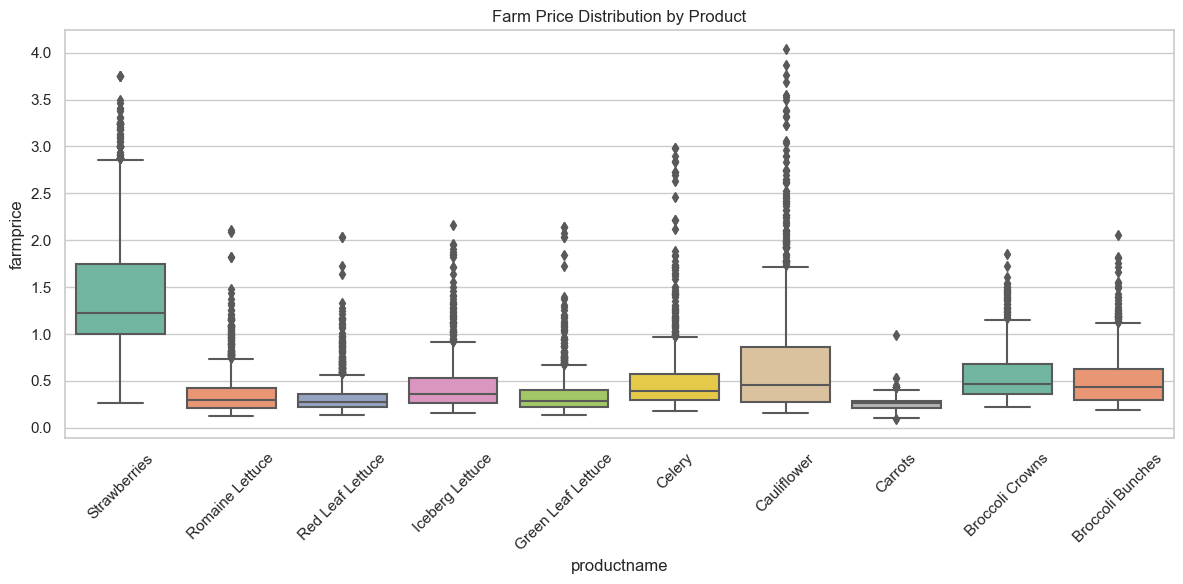

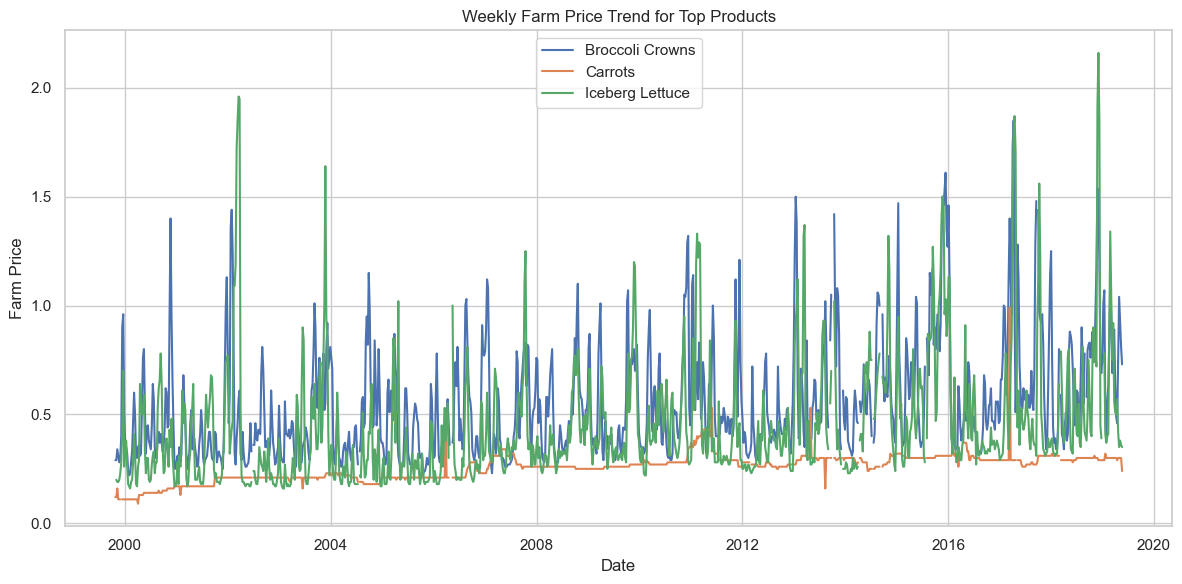

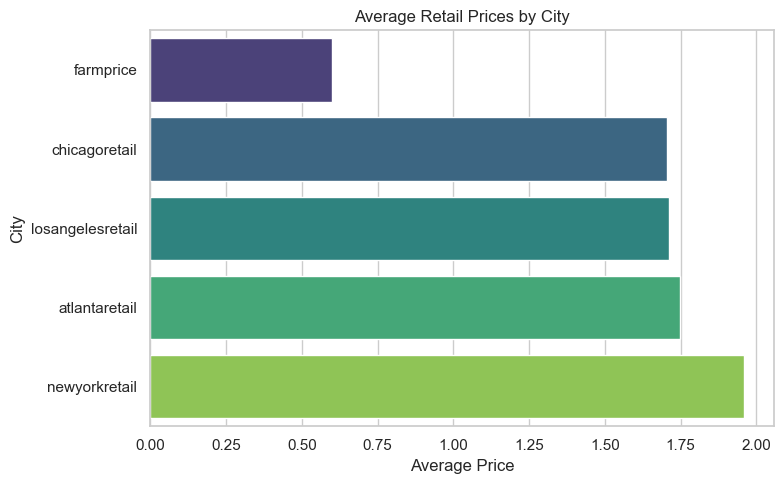

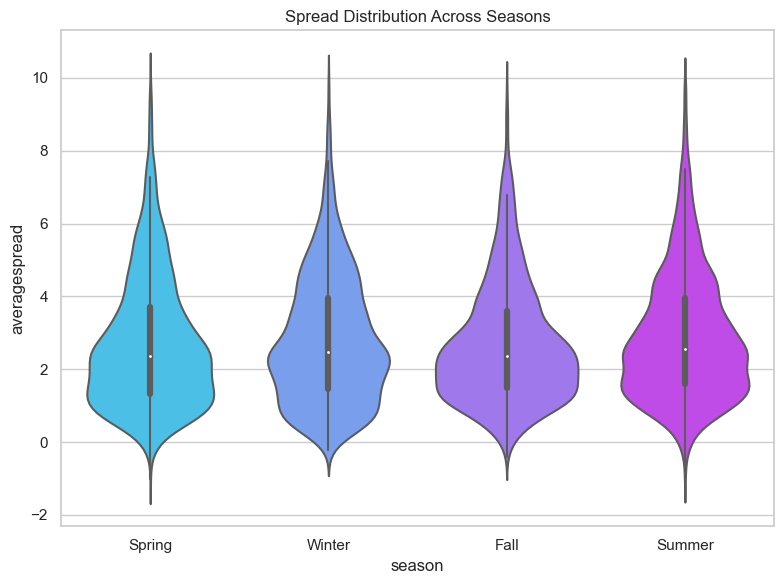

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

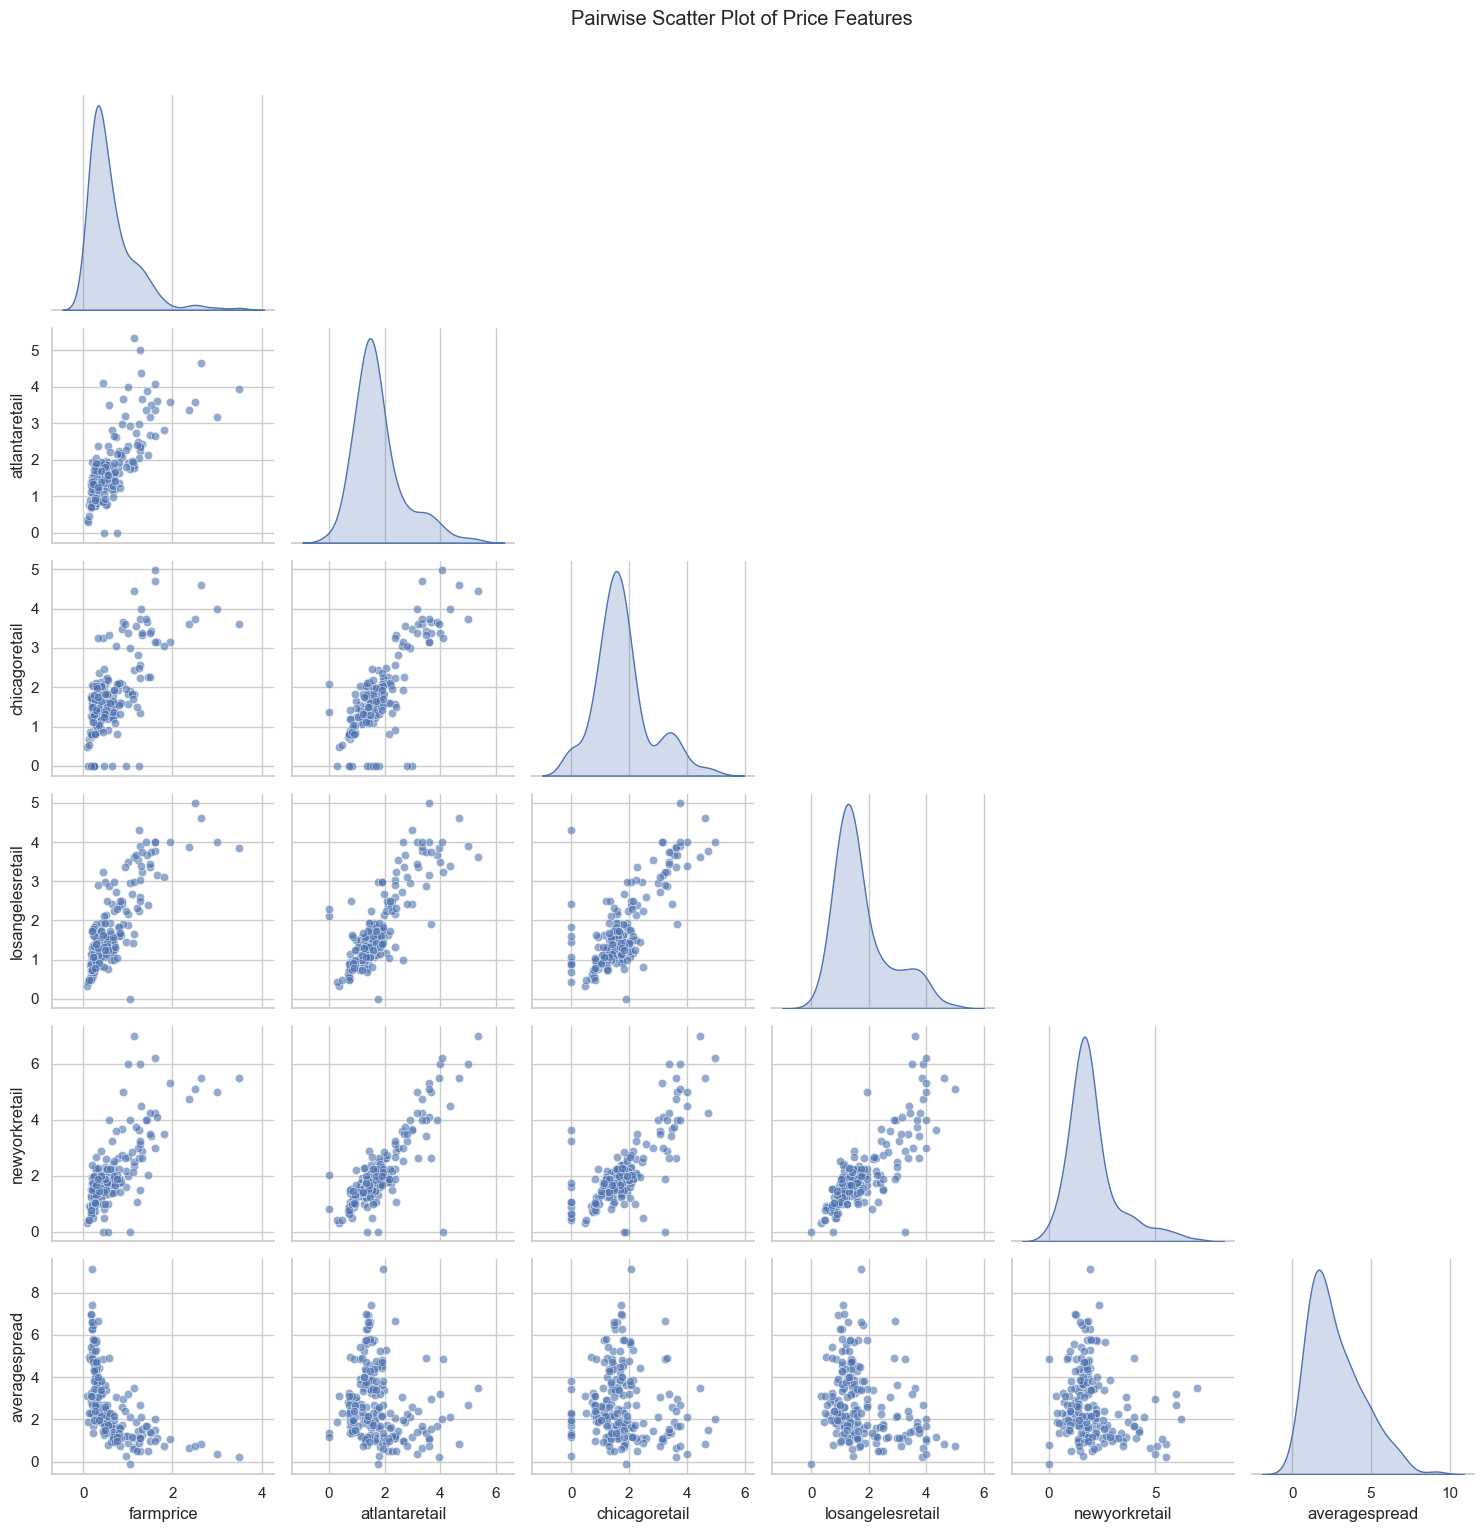

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv(r"C:\Users\prana\Downloads\ProductPriceIndex.csv")
except FileNotFoundError:
    df = pd.read_csv('/mnt/data/ProductPriceIndex.csv')

# Clean and convert relevant columns
price_cols = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for col in price_cols:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
df['averagespread'] = pd.to_numeric(df['averagespread'].str.rstrip('%'), errors='coerce') / 100

# Drop rows with missing values
df = df.dropna(subset=price_cols + ['averagespread', 'date', 'productname'])

# Parse date and create temporal features
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(lambda m: 'Winter' if m in [12,1,2] else 'Spring' if m in [3,4,5] else 'Summer' if m in [6,7,8] else 'Fall')

# Set seaborn style
sns.set(style='whitegrid')

# 2. Boxplot of farm prices by product (top 10)
plt.figure(figsize=(12, 6))
top_products = df['productname'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['productname'].isin(top_products)], x='productname', y='farmprice', palette='Set2')
plt.title("Farm Price Distribution by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Line plot: farm price trend over time for top 3 products
plt.figure(figsize=(12, 6))
for product in top_products[:3]:
    subset = df[df['productname'] == product]
    weekly = subset.set_index('date')['farmprice'].resample('W').mean()
    plt.plot(weekly.index, weekly.values, label=product)
plt.title("Weekly Farm Price Trend for Top Products")
plt.xlabel("Date")
plt.ylabel("Farm Price")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bar plot: average retail prices per city
avg_prices = df[price_cols].mean().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_prices.values, y=avg_prices.index, palette='viridis')
plt.title("Average Retail Prices by City")
plt.xlabel("Average Price")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# 5. Violin plot: Spread distribution by season
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='season', y='averagespread', palette='cool')
plt.title("Spread Distribution Across Seasons")
plt.tight_layout()
plt.show()

# 6. Pairplot: Relationships between price features
sampled_df = df[price_cols + ['averagespread']].dropna().sample(n=200, random_state=1)
sns.pairplot(sampled_df, diag_kind='kde', corner=True, plot_kws={'alpha':0.6})
plt.suptitle("Pairwise Scatter Plot of Price Features", y=1.02)
plt.tight_layout()
plt.show()


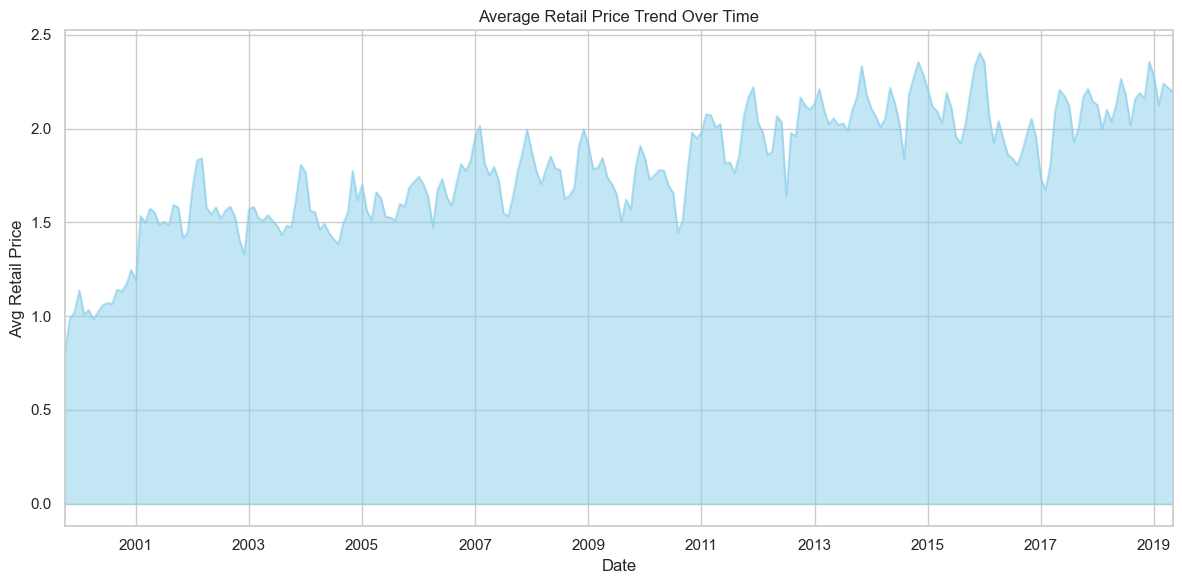

In [3]:
# Area chart for cumulative average retail prices over time
df['avg_retail'] = df[['atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']].mean(axis=1)
area_df = df.groupby('date')['avg_retail'].mean().sort_index()

area_df = area_df.resample('M').mean()
area_df.plot(kind='area', figsize=(12,6), alpha=0.5, color='skyblue')
plt.title("Average Retail Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Retail Price")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


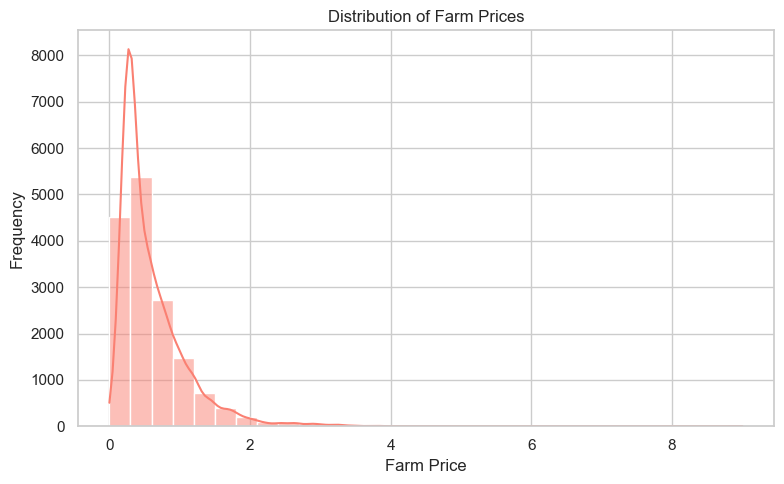

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['farmprice'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Farm Prices")
plt.xlabel("Farm Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


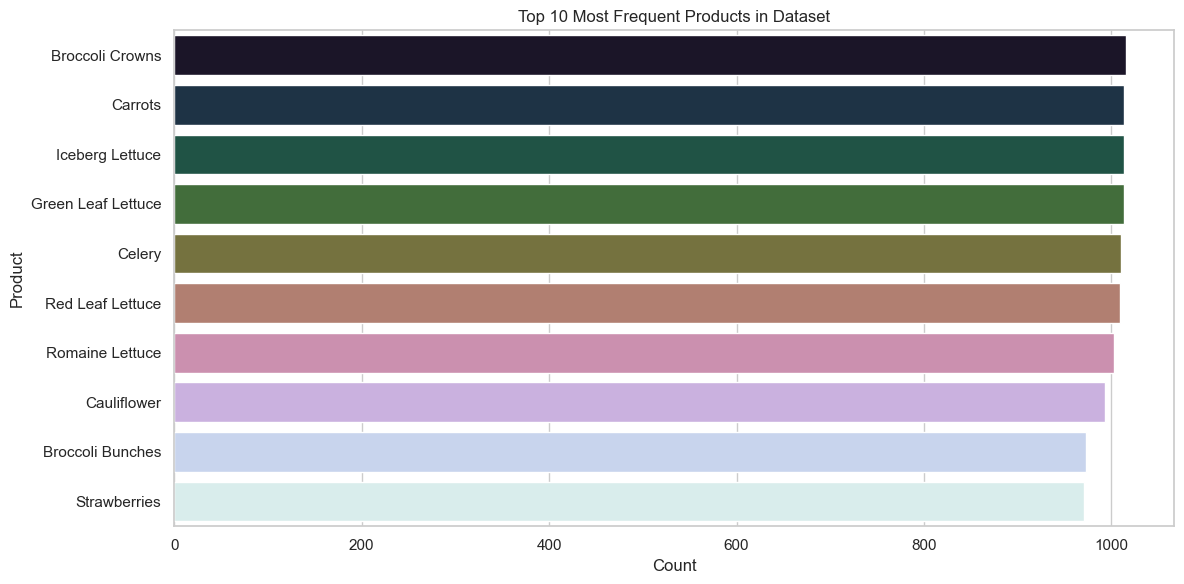

In [6]:
plt.figure(figsize=(12,6))
top_names = df['productname'].value_counts().nlargest(10).index
sns.countplot(data=df[df['productname'].isin(top_names)], y='productname', order=top_names, palette='cubehelix')
plt.title("Top 10 Most Frequent Products in Dataset")
plt.xlabel("Count")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_14488\3539863445.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x='season', y='farmprice', jitter=True, palette='viridis')
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


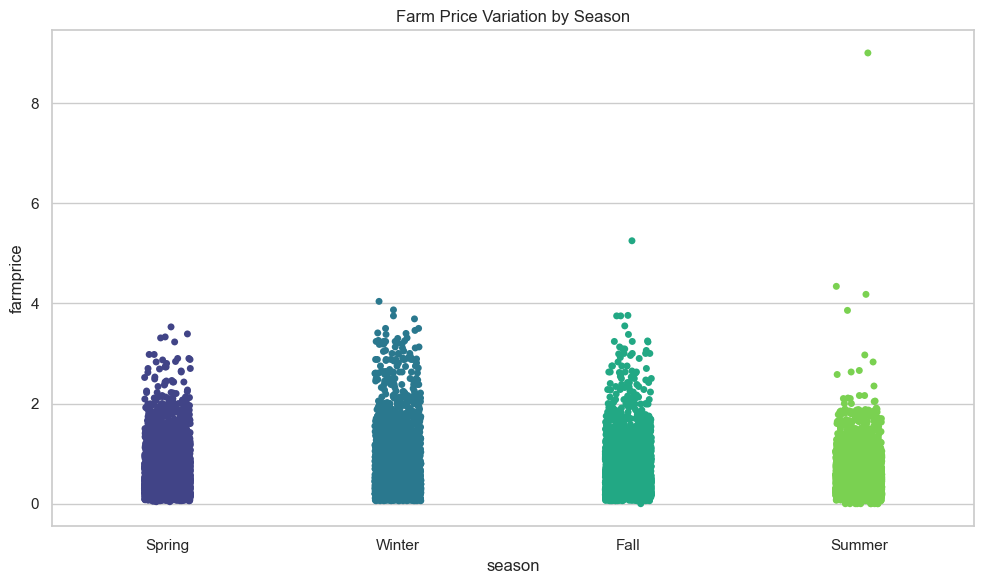

In [7]:
plt.figure(figsize=(10,6))
sns.stripplot(data=df, x='season', y='farmprice', jitter=True, palette='viridis')
plt.title("Farm Price Variation by Season")
plt.tight_layout()
plt.show()


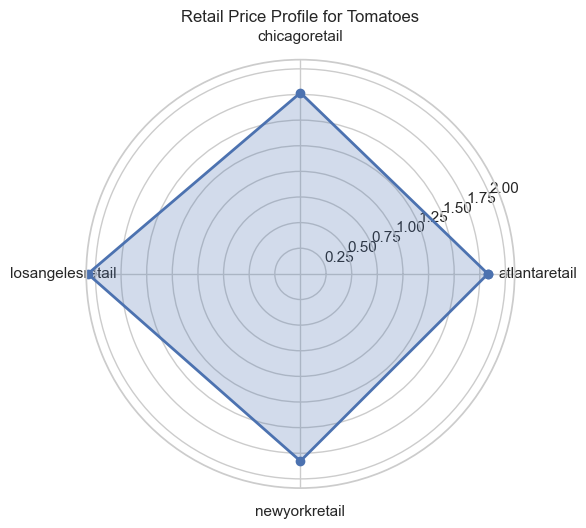

In [8]:
# Radar chart for a specific product (e.g., 'Tomatoes') average price by city
import numpy as np

product = 'Tomatoes'
avg_vals = df[df['productname'] == product][['atlantaretail','chicagoretail','losangelesretail','newyorkretail']].mean()

labels = avg_vals.index.tolist()
values = avg_vals.values.tolist()
values += values[:1]  # close the circle

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title(f"Retail Price Profile for {product}")
plt.tight_layout()
plt.show()
